2024-02-21 23:26:08 INFO     [Epoch   1]   Loss:    0.7235     Train Acc:      50.0%      Val Acc:      50.0%
2024-02-21 23:26:08 INFO     [Epoch   1]   Train Misclassification Error:      50.0%     Test Misclassification Error:      50.0%
2024-02-21 23:26:09 INFO     [Epoch   2]   Loss:    0.6896     Train Acc:      50.0%      Val Acc:     50.05%
2024-02-21 23:26:09 INFO     [Epoch   2]   Train Misclassification Error:      50.0%     Test Misclassification Error:     49.95%
2024-02-21 23:26:10 INFO     [Epoch   3]   Loss:    0.6586     Train Acc:     50.94%      Val Acc:      53.8%
2024-02-21 23:26:10 INFO     [Epoch   3]   Train Misclassification Error:     49.06%     Test Misclassification Error:      46.2%
2024-02-21 23:26:10 INFO     [Epoch   4]   Loss:    0.6336     Train Acc:     56.51%      Val Acc:      59.6%
2024-02-21 23:26:10 INFO     [Epoch   4]   Train Misclassification Error:     43.49%     Test Misclassification Error:      40.4%
2024-02-21 23:26:11 INFO     [Epoch   5]

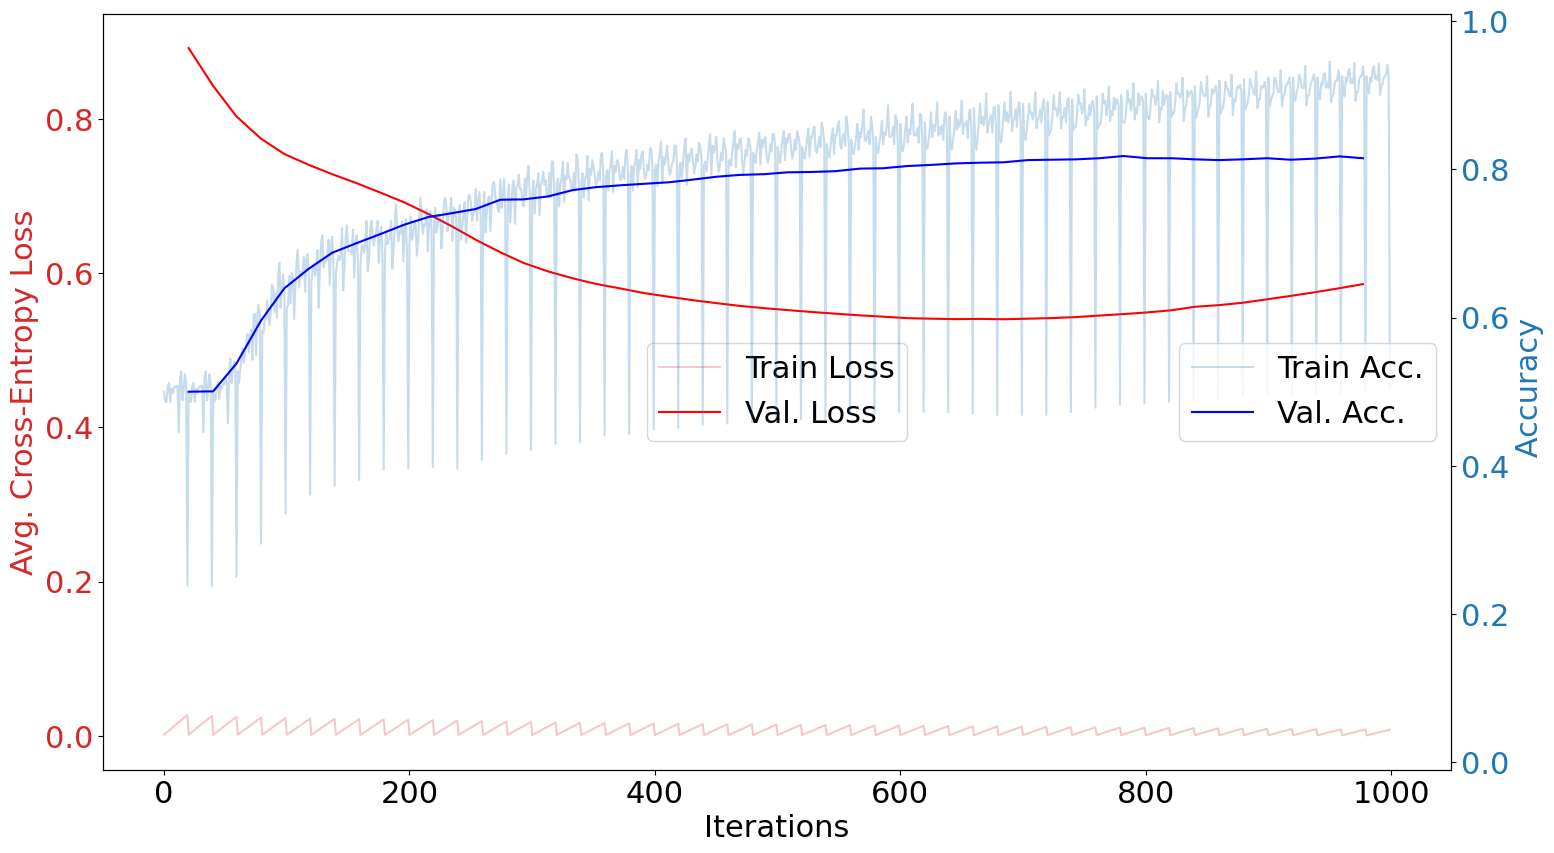

In [ ]:
"""
DHARUN NARAYANAN LAKSHMINARAYANAN KOMETHAGAVELU
"""

from turtle import width
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
font = {'weight' : 'normal','size'   : 22}
matplotlib.rc('font', **font)
import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')



######################################################
# Q1 Implement Init, Forward, and Backward For Layers
######################################################


class SigmoidCrossEntropy:

  # Compute the cross entropy loss after sigmoid. The reason they are put into the same layer is because the gradient has a simpler form
  # logits -- batch_size x num_classes set of scores, logits[i,j] is score of class j for batch element i
  # labels -- batch_size x 1 vector of integer label id (0,1) where labels[i] is the label for batch element i
  #
  # TODO: Output should be a positive scalar value equal to the average cross entropy loss after sigmoid
    def forward(self, logits, labels):
        self.sig = self.sigmoid(logits)
        self.loss = -np.mean(labels * np.log(self.sig + 1e-15) + (1 - labels) * np.log(1 - self.sig + 1e-15))
        self.labels = labels
        return self.loss


  # TODO: Compute the gradient of the cross entropy loss with respect to the the input logits
    def backward(self):
        self.grad = self.sig - self.labels
        return self.grad

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -15, 15)))



class ReLU:

  # TODO: Compute ReLU(input) element-wise
    def forward(self, input):
        self.input = input
        return np.maximum(0, input)

  # TODO: Given dL/doutput, return dL/dinput
    def backward(self, grad):
        grad_input = grad * (self.input > 0)
        return grad_input

  # No parameters so nothing to do during a gradient descent step
    def step(self,step_size, momentum = 0, weight_decay = 0):
        return


class LinearLayer:

  # TODO: Initialize our layer with (input_dim, output_dim) weight matrix and a (1,output_dim) bias vector
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.W = np.random.randn(output_dim, input_dim) * np.sqrt(2 / (input_dim + output_dim))
        self.b = np.zeros((1, output_dim))
        self.grad_weights = None
        self.grad_bias = None
        self.input = None
        self.output = None
        self.prev_grad_weights = np.zeros_like(self.W)
        self.prev_grad_bias = np.zeros_like(self.b)


  # TODO: During the forward pass, we simply compute XW+b
    def forward(self, input):
        self.input = input
        self.output = np.dot(input, self.W.T) + self.b
        return self.output


  # TODO: Backward pass inputs:
  #
  # grad dL/dZ -- For a batch size of n, grad is a (n x output_dim) matrix where
  #         the i'th row is the gradient of the loss of example i with respect
  #         to z_i (the output of this layer for example i)

  # Computes and stores:
  #
  # self.grad_weights dL/dW --  A (input_dim x output_dim) matrix storing the gradient
  #                       of the loss with respect to the weights of this layer.
  #                       This is an summation over the gradient of the loss of
  #                       each example with respect to the weights.
  #
  # self.grad_bias dL/dZ--     A (1 x output_dim) matrix storing the gradient
  #                       of the loss with respect to the bias of this layer.
  #                       This is an summation over the gradient of the loss of
  #                       each example with respect to the bias.

  # Return Value:
  #
  # grad_input dL/dX -- For a batch size of n, grad_input is a (n x input_dim) matrix where
  #               the i'th row is the gradient of the loss of example i with respect
  #               to x_i (the input of this layer for example i)

    def backward(self, grad):
        if grad is None:
            raise ValueError("Gradient is None")
        self.grad_weights = np.dot(self.input.T, grad)
        self.grad_bias = np.sum(grad, axis=0, keepdims=True)
        grad_input = np.dot(grad, self.W)
        return grad_input


  ######################################################
  # Q2 Implement SGD with Weight Decay
  ######################################################
    def step(self, step_size, momentum = 0.8, weight_decay = 0.0):
        self.prev_grad_weights = momentum * self.prev_grad_weights + (1 - momentum) * (self.grad_weights.T + weight_decay * self.W)
        self.prev_grad_bias = momentum * self.prev_grad_bias + (1 - momentum) * self.grad_bias
        self.W -= step_size * self.prev_grad_weights
        self.b -= step_size * self.prev_grad_bias



######################################################
# Q4 Implement Evaluation for Monitoring Training
######################################################

# TODO: Given a model, X/Y dataset, and batch size, return the average cross-entropy loss and accuracy over the set
def evaluate(model, X_val, Y_val, batch_size):
  sce = SigmoidCrossEntropy()
  total_loss = 0
  correct = 0

  for i in range(0, X_val.shape[0], batch_size):
    X_batch = X_val[i:i+batch_size]
    Y_batch = Y_val[i:i+batch_size]

    logits = model.forward(X_batch)
    loss = sce.forward(logits, Y_batch)

    total_loss += loss
    predictions = (logits > 0.5).astype(int)
    correct += np.sum(predictions == Y_batch)

  avg_loss = total_loss / (X_val.shape[0] // batch_size)
  accuracy = correct / X_val.shape[0]
  return avg_loss, accuracy


def main():

  # TODO: Set optimization parameters (NEED TO SUPPLY THESE)
    batch_size = 512
    max_epochs = 50
    step_size = 0.0001

    number_of_layers = 4
    width_of_layers = 64
    weight_decay = 0.0001
    momentum = 0.85


  # Load data
    data = pickle.load(open('cifar_2class_py3.p', 'rb'))
    X_train = data['train_data']
    Y_train = data['train_labels']
    X_test = data['test_data']
    Y_test = data['test_labels']

    Xmean = np.mean(X_train, axis=0)
    X_train = (X_train-Xmean)/255.0
    X_test = (X_test-Xmean)/255.0

  # Some helpful dimensions
    num_examples, input_dim = X_train.shape
    output_dim = 1 # number of class labels -1 for sigmoid loss


  # Build a network with input feature dimensions, output feature dimension,
  # hidden dimension, and number of layers as specified below. You can edit this as you please.
    net = FeedForwardNeuralNetwork(input_dim, output_dim, width_of_layers, number_of_layers)

  # Some lists for book-keeping for plotting later
    losses = []
    val_losses = []
    accs = []
    val_accs = []
    train_misclassification_errors = []
    test_misclassification_errors = []


    for epoch in range(max_epochs):

        epoch_loss = 0
        correct_train = 0
        misclassification_train = 0

        for i in range(0, num_examples, batch_size):
            X_batch = X_train[i:i + batch_size]
            Y_batch = Y_train[i:i + batch_size]

            logits = net.forward(X_batch)

            sce = SigmoidCrossEntropy()
            loss = sce.forward(logits, Y_batch)
            epoch_loss += loss

            predictions = (logits > 0.5).astype(int)
            correct_train += np.sum(predictions == Y_batch)
            misclassification_train += np.sum(predictions != Y_batch)

            grad = sce.backward()
            net.backward(grad)
            net.step(step_size, momentum, weight_decay)

            batch_avg_loss = epoch_loss / batch_size
            batch_accuracy = np.sum(predictions == Y_batch) / batch_size
            losses.append(batch_avg_loss)
            accs.append(batch_accuracy)

        epoch_avg_loss = epoch_loss / (num_examples // batch_size)
        epoch_avg_acc = correct_train / num_examples
        epoch_misclassification_error_train = misclassification_train / num_examples

        val_loss, val_acc = evaluate(net, X_test, Y_test, batch_size)
        val_accs.append(val_acc)
        val_losses.append(val_loss)

        # Evaluation of misclassification error rate for training and testing
        misclassification_error_train = 1 - epoch_avg_acc
        misclassification_error_test = 1 - val_acc

        train_misclassification_errors.append(misclassification_error_train)
        test_misclassification_errors.append(misclassification_error_test)

        ###############################################################
        # Print some stats about the optimization process after each epoch
        ###############################################################
        # epoch_avg_loss -- average training loss across batches this epoch
        # epoch_avg_acc -- average accuracy across batches this epoch
        # vacc -- testing accuracy this epoch
        ###############################################################

        logging.info("[Epoch {:3}]   Loss:  {:8.4}     Train Acc:  {:8.4}%      Val Acc:  {:8.4}%".format(epoch+1, epoch_avg_loss, epoch_avg_acc * 100, val_acc * 100))
        logging.info("[Epoch {:3}]   Train Misclassification Error:  {:8.4}%     Test Misclassification Error:  {:8.4}%".format(epoch+1, misclassification_error_train * 100, misclassification_error_test * 100))



    ###############################################################
    # Code for producing output plot requires
    ###############################################################
    # losses -- a list of average loss per batch in training
    # accs -- a list of accuracies per batch in training
    # val_losses -- a list of average testing loss at each epoch
    # val_acc -- a list of testing accuracy at each epoch
    # batch_size -- the batch size
    ################################################################

    # Plot training and testing curves
    fig, ax1 = plt.subplots(figsize=(16,9))
    color = 'tab:red'
    ax1.plot(range(len(losses)), losses, c=color, alpha=0.25, label="Train Loss")
    ax1.plot([np.ceil((i+1)*len(X_train)/batch_size) for i in range(len(val_losses))], val_losses,c="red", label="Val. Loss")
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Avg. Cross-Entropy Loss", c=color)
    ax1.tick_params(axis='y', labelcolor=color)
    #ax1.set_ylim(-0.01,3)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.plot(range(len(losses)), accs, c=color, label="Train Acc.", alpha=0.25)
    ax2.plot([np.ceil((i+1)*len(X_train)/batch_size) for i in range(len(val_accs))], val_accs,c="blue", label="Val. Acc.")
    ax2.set_ylabel(" Accuracy", c=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(-0.01,1.01)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    ax1.legend(loc="center")
    ax2.legend(loc="center right")
    plt.show()



#####################################################
# Feedforward Neural Network Structure
# -- Feel free to edit when tuning
#####################################################

class FeedForwardNeuralNetwork:

    def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
        if num_layers == 1:
            self.layers = [LinearLayer(input_dim, output_dim)]
        else:
            self.layers = [LinearLayer(input_dim, hidden_dim)]
            self.layers.append(ReLU())  # ReLU activation after input layer
            for _ in range(num_layers - 2):
                self.layers.append(LinearLayer(hidden_dim, hidden_dim))
                self.layers.append(ReLU())  # ReLU activation after each hidden layer
            # Output layer
            self.layers.append(LinearLayer(hidden_dim, output_dim))

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

    def step(self, step_size, momentum, weight_decay):
        for layer in self.layers:
            layer.step(step_size, momentum, weight_decay)



def displayExample(x):
  r = x[:1024].reshape(32,32)
  g = x[1024:2048].reshape(32,32)
  b = x[2048:].reshape(32,32)

  plt.imshow(np.stack([r,g,b],axis=2))
  plt.axis('off')
  plt.show()


if __name__=="__main__":
  main()

2024-02-22 00:01:48 INFO     Training with batch size: 8
2024-02-22 00:02:42 INFO     Training with batch size: 16
2024-02-22 00:03:15 INFO     Training with batch size: 32
2024-02-22 00:03:41 INFO     Training with batch size: 64
2024-02-22 00:04:02 INFO     Training with batch size: 128
2024-02-22 00:04:24 INFO     Training with batch size: 256
2024-02-22 00:04:42 INFO     Training with batch size: 512
2024-02-22 00:04:57 INFO     Training with batch size: 1024
2024-02-22 00:05:16 INFO     Training with learning rate: 1e-06
2024-02-22 00:05:35 INFO     Training with learning rate: 1e-05
2024-02-22 00:06:00 INFO     Training with learning rate: 0.0001
2024-02-22 00:06:27 INFO     Training with learning rate: 0.001
2024-02-22 00:06:49 INFO     Training with learning rate: 0.01
2024-02-22 00:07:13 INFO     Training with learning rate: 0.1
2024-02-22 00:07:38 INFO     Training with hidden units: 8
2024-02-22 00:07:55 INFO     Training with hidden units: 16
2024-02-22 00:08:20 INFO     Tr

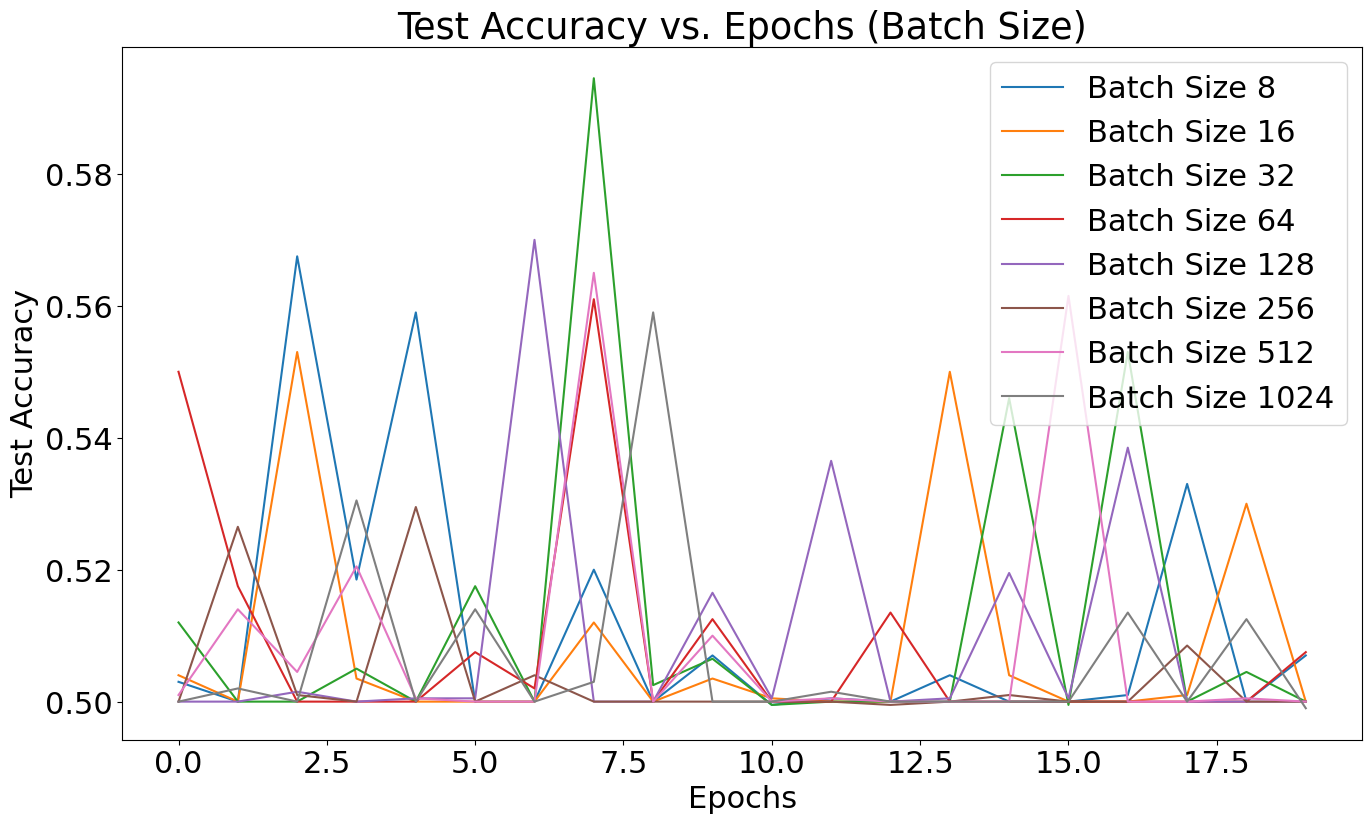

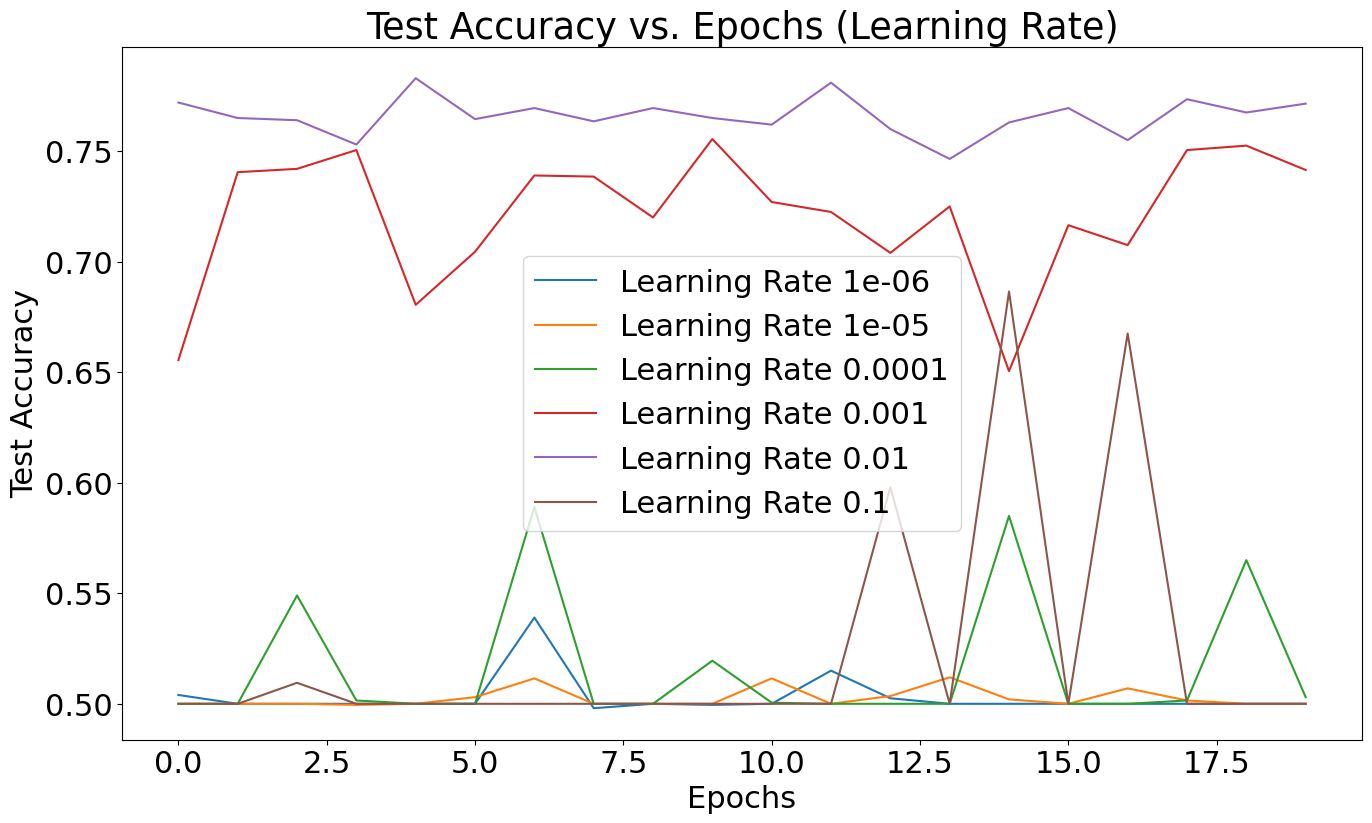

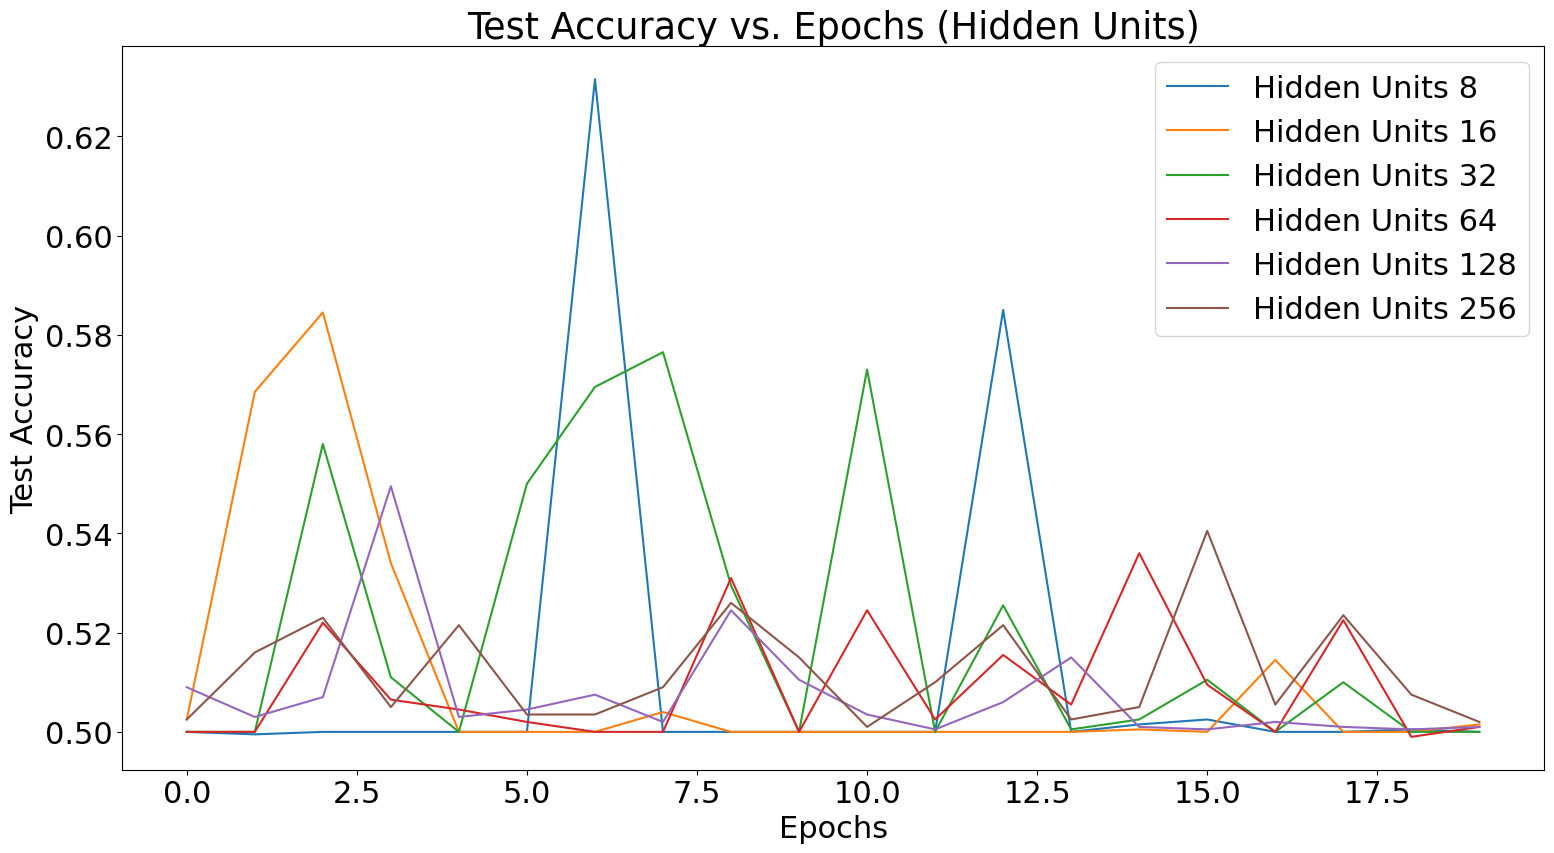

In [ ]:
"""
DHARUN NARAYANAN LAKSHMINARAYANAN KOMETHAGAVELU
"""

from turtle import width
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
font = {'weight' : 'normal','size'   : 22}
matplotlib.rc('font', **font)
import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')



######################################################
# Q1 Implement Init, Forward, and Backward For Layers
######################################################


class SigmoidCrossEntropy:

  # Compute the cross entropy loss after sigmoid. The reason they are put into the same layer is because the gradient has a simpler form
  # logits -- batch_size x num_classes set of scores, logits[i,j] is score of class j for batch element i
  # labels -- batch_size x 1 vector of integer label id (0,1) where labels[i] is the label for batch element i
  #
  # TODO: Output should be a positive scalar value equal to the average cross entropy loss after sigmoid
    def forward(self, logits, labels):
        self.sig = self.sigmoid(logits)
        self.loss = -np.mean(labels * np.log(self.sig + 1e-15) + (1 - labels) * np.log(1 - self.sig + 1e-15))
        self.labels = labels
        return self.loss


  # TODO: Compute the gradient of the cross entropy loss with respect to the the input logits
    def backward(self):
        self.grad = self.sig - self.labels
        return self.grad

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -15, 15)))



class ReLU:

  # TODO: Compute ReLU(input) element-wise
    def forward(self, input):
        self.input = input
        return np.maximum(0, input)

  # TODO: Given dL/doutput, return dL/dinput
    def backward(self, grad):
        grad_input = grad * (self.input > 0)
        return grad_input

  # No parameters so nothing to do during a gradient descent step
    def step(self,step_size, momentum = 0, weight_decay = 0):
        return


class LinearLayer:

  # TODO: Initialize our layer with (input_dim, output_dim) weight matrix and a (1,output_dim) bias vector
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.W = np.random.randn(output_dim, input_dim) * np.sqrt(2 / (input_dim + output_dim))
        self.b = np.zeros((1, output_dim))
        self.grad_weights = None
        self.grad_bias = None
        self.input = None
        self.output = None
        self.prev_grad_weights = np.zeros_like(self.W)
        self.prev_grad_bias = np.zeros_like(self.b)


  # TODO: During the forward pass, we simply compute XW+b
    def forward(self, input):
        self.input = input
        self.output = np.dot(input, self.W.T) + self.b
        return self.output


  # TODO: Backward pass inputs:
  #
  # grad dL/dZ -- For a batch size of n, grad is a (n x output_dim) matrix where
  #         the i'th row is the gradient of the loss of example i with respect
  #         to z_i (the output of this layer for example i)

  # Computes and stores:
  #
  # self.grad_weights dL/dW --  A (input_dim x output_dim) matrix storing the gradient
  #                       of the loss with respect to the weights of this layer.
  #                       This is an summation over the gradient of the loss of
  #                       each example with respect to the weights.
  #
  # self.grad_bias dL/dZ--     A (1 x output_dim) matrix storing the gradient
  #                       of the loss with respect to the bias of this layer.
  #                       This is an summation over the gradient of the loss of
  #                       each example with respect to the bias.

  # Return Value:
  #
  # grad_input dL/dX -- For a batch size of n, grad_input is a (n x input_dim) matrix where
  #               the i'th row is the gradient of the loss of example i with respect
  #               to x_i (the input of this layer for example i)

    def backward(self, grad):
        if grad is None:
            raise ValueError("Gradient is None")
        self.grad_weights = np.dot(self.input.T, grad)
        self.grad_bias = np.sum(grad, axis=0, keepdims=True)
        grad_input = np.dot(grad, self.W)
        return grad_input


  ######################################################
  # Q2 Implement SGD with Weight Decay
  ######################################################
    def step(self, step_size, momentum = 0.8, weight_decay = 0.0):
        self.prev_grad_weights = momentum * self.prev_grad_weights + (1 - momentum) * (self.grad_weights.T + weight_decay * self.W)
        self.prev_grad_bias = momentum * self.prev_grad_bias + (1 - momentum) * self.grad_bias
        self.W -= step_size * self.prev_grad_weights
        self.b -= step_size * self.prev_grad_bias

class FeedForwardNeuralNetwork:

    def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
        if num_layers == 1:
            self.layers = [LinearLayer(input_dim, output_dim)]
        else:
            self.layers = [LinearLayer(input_dim, hidden_dim)]
            self.layers.append(ReLU())  # ReLU activation after input layer
            for _ in range(num_layers - 2):
                self.layers.append(LinearLayer(hidden_dim, hidden_dim))
                self.layers.append(ReLU())  # ReLU activation after each hidden layer
            # Output layer
            self.layers.append(LinearLayer(hidden_dim, output_dim))

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

    def step(self, step_size, momentum, weight_decay):
        for layer in self.layers:
            layer.step(step_size, momentum, weight_decay)


######################################################
# Q4 Implement Evaluation for Monitoring Training
######################################################

# TODO: Given a model, X/Y dataset, and batch size, return the average cross-entropy loss and accuracy over the set
def evaluate(model, X_val, Y_val, batch_size):
  sce = SigmoidCrossEntropy()
  total_loss = 0
  correct = 0

  for i in range(0, X_val.shape[0], batch_size):
    X_batch = X_val[i:i+batch_size]
    Y_batch = Y_val[i:i+batch_size]

    logits = model.forward(X_batch)
    loss = sce.forward(logits, Y_batch)

    total_loss += loss
    predictions = (logits > 0.5).astype(int)
    correct += np.sum(predictions == Y_batch)

  avg_loss = total_loss / (X_val.shape[0] // batch_size)
  accuracy = correct / X_val.shape[0]
  return avg_loss, accuracy


def main():
    # Load data
    data = pickle.load(open('cifar_2class_py3.p', 'rb'))
    X_train = data['train_data']
    Y_train = data['train_labels']
    X_test = data['test_data']
    Y_test = data['test_labels']
    Xmean = np.mean(X_train, axis=0)
    X_train = (X_train - Xmean) / 255.0
    X_test = (X_test - Xmean) / 255.0

    # Parameters
    max_epochs = 20
    width_of_layers = 16
    number_of_layers = 4
    hidden_units_list = [8, 16, 32, 64, 128, 256]
    learning_rates = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
    batch_sizes = [8, 16, 32, 64, 128, 256, 512, 1024]

    # Results storage
    results_batch_size = {}
    results_learning_rate = {}
    results_hidden_units = {}

    for batch_size in batch_sizes:
        logging.info(f"Training with batch size: {batch_size}")
        results_batch_size[batch_size] = []
        for _ in range(max_epochs):
            model = FeedForwardNeuralNetwork(X_train.shape[1], 1, width_of_layers, number_of_layers)
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i + batch_size]
                Y_batch = Y_train[i:i + batch_size]
                logits = model.forward(X_batch)
                sce = SigmoidCrossEntropy()
                loss = sce.forward(logits, Y_batch)
                grad = sce.backward()
                model.backward(grad)
                model.step(0.0001, momentum=0.8, weight_decay=0.001)
            val_loss, val_acc = evaluate(model, X_test, Y_test, batch_size)
            results_batch_size[batch_size].append(val_acc)

    for learning_rate in learning_rates:
        logging.info(f"Training with learning rate: {learning_rate}")
        results_learning_rate[learning_rate] = []
        for _ in range(max_epochs):
            model = FeedForwardNeuralNetwork(X_train.shape[1], 1, width_of_layers, number_of_layers)
            for i in range(0, X_train.shape[0], 32):
                X_batch = X_train[i:i + 32]
                Y_batch = Y_train[i:i + 32]
                logits = model.forward(X_batch)
                sce = SigmoidCrossEntropy()
                loss = sce.forward(logits, Y_batch)
                grad = sce.backward()
                model.backward(grad)
                model.step(learning_rate, momentum=0.8, weight_decay=0.001)
            val_loss, val_acc = evaluate(model, X_test, Y_test, 32)
            results_learning_rate[learning_rate].append(val_acc)

    for hidden_units in hidden_units_list:
        logging.info(f"Training with hidden units: {hidden_units}")
        results_hidden_units[hidden_units] = []
        for _ in range(max_epochs):
            model = FeedForwardNeuralNetwork(X_train.shape[1], 1, hidden_units, number_of_layers)
            for i in range(0, X_train.shape[0], 32):
                X_batch = X_train[i:i + 32]
                Y_batch = Y_train[i:i + 32]
                logits = model.forward(X_batch)
                sce = SigmoidCrossEntropy()
                loss = sce.forward(logits, Y_batch)
                grad = sce.backward()
                model.backward(grad)
                model.step(0.0001, momentum=0.8, weight_decay=0.001)
            val_loss, val_acc = evaluate(model, X_test, Y_test, 32)
            results_hidden_units[hidden_units].append(val_acc)

    # Plotting
    plt.figure(figsize=(16,9))
    for batch_size, accs in results_batch_size.items():
        plt.plot(accs, label=f"Batch Size {batch_size}")
    plt.xlabel("Epochs")
    plt.ylabel("Test Accuracy")
    plt.title("Test Accuracy vs. Epochs (Batch Size)")
    plt.legend()

    plt.figure(figsize=(16,9))
    for learning_rate, accs in results_learning_rate.items():
        plt.plot(accs, label=f"Learning Rate {learning_rate}")
    plt.xlabel("Epochs")
    plt.ylabel("Test Accuracy")
    plt.title("Test Accuracy vs. Epochs (Learning Rate)")
    plt.legend()

    plt.figure(figsize=(16,9))
    for hidden_units, accs in results_hidden_units.items():
        plt.plot(accs, label=f"Hidden Units {hidden_units}")
    plt.xlabel("Epochs")
    plt.ylabel("Test Accuracy")
    plt.title("Test Accuracy vs. Epochs (Hidden Units)")
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


2024-02-21 23:48:25 INFO     Training with batch size: 8
2024-02-21 23:49:13 INFO     Training with batch size: 16
2024-02-21 23:49:41 INFO     Training with batch size: 32
2024-02-21 23:50:05 INFO     Training with batch size: 64
2024-02-21 23:50:26 INFO     Training with batch size: 128
2024-02-21 23:50:44 INFO     Training with batch size: 256
2024-02-21 23:51:06 INFO     Training with batch size: 512
2024-02-21 23:51:19 INFO     Training with batch size: 1024
2024-02-21 23:51:45 INFO     Training with learning rate: 1e-06
2024-02-21 23:52:11 INFO     Training with learning rate: 1e-05
2024-02-21 23:52:33 INFO     Training with learning rate: 0.0001
2024-02-21 23:53:02 INFO     Training with learning rate: 0.001
2024-02-21 23:53:21 INFO     Training with learning rate: 0.01
2024-02-21 23:53:46 INFO     Training with learning rate: 0.1
2024-02-21 23:54:10 INFO     Training with hidden units: 8
2024-02-21 23:54:29 INFO     Training with hidden units: 16
2024-02-21 23:54:50 INFO     Tr

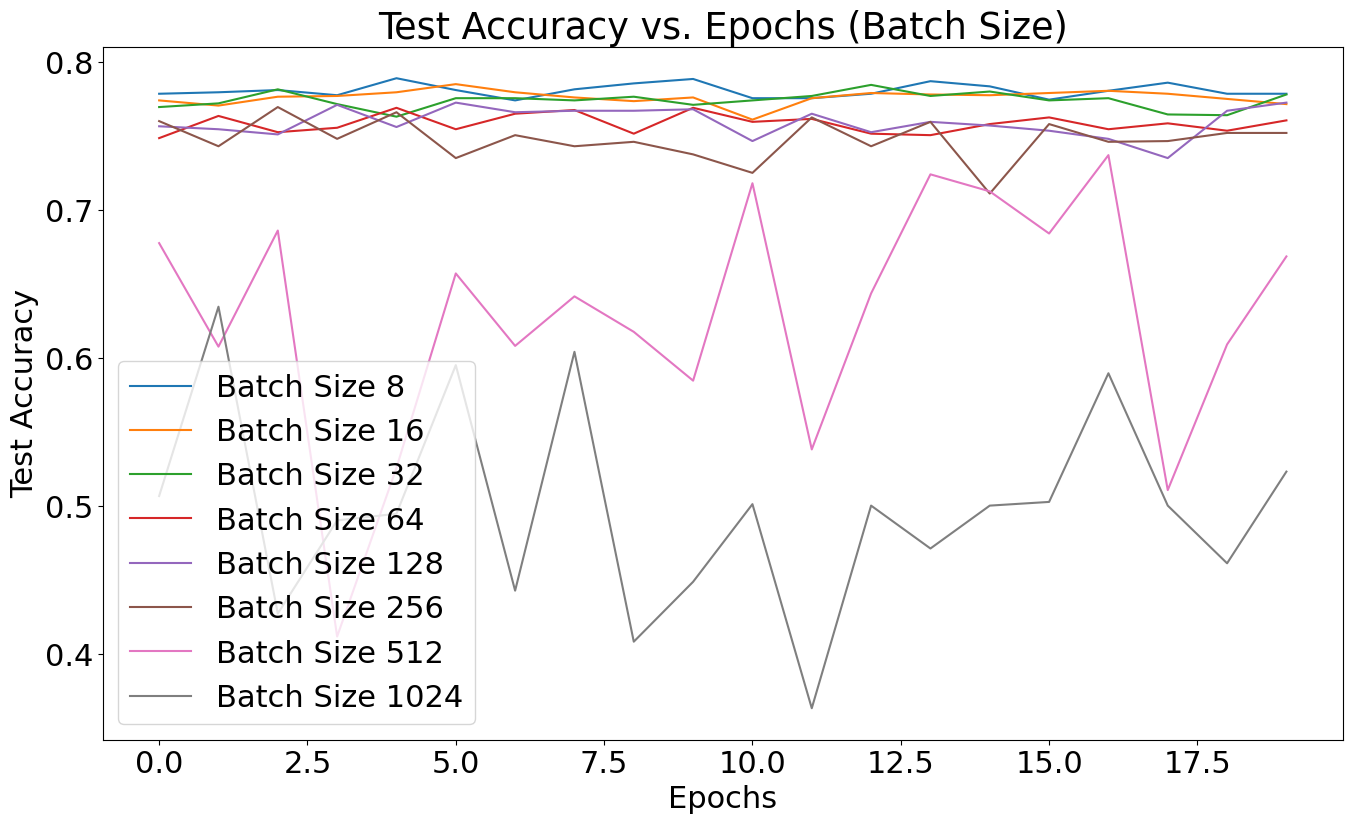

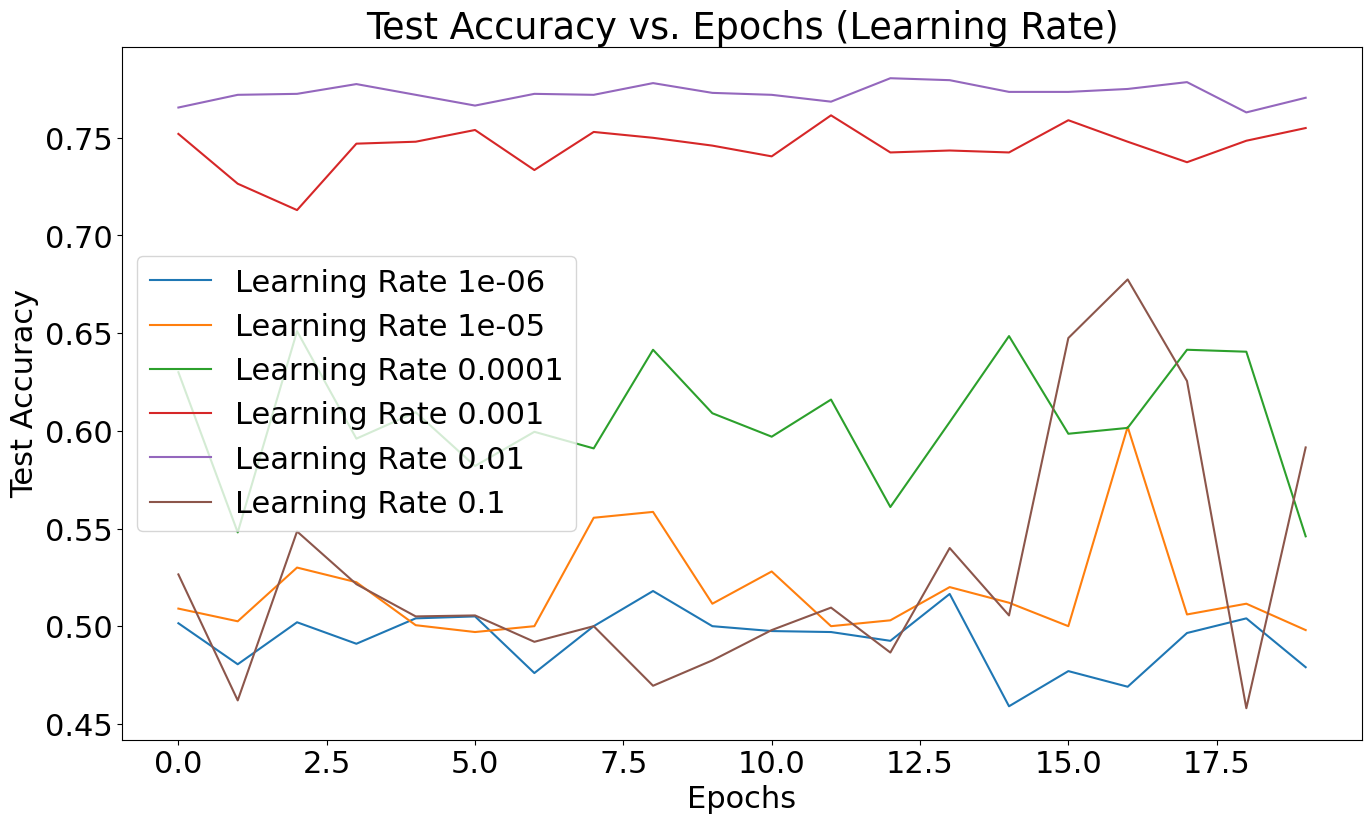

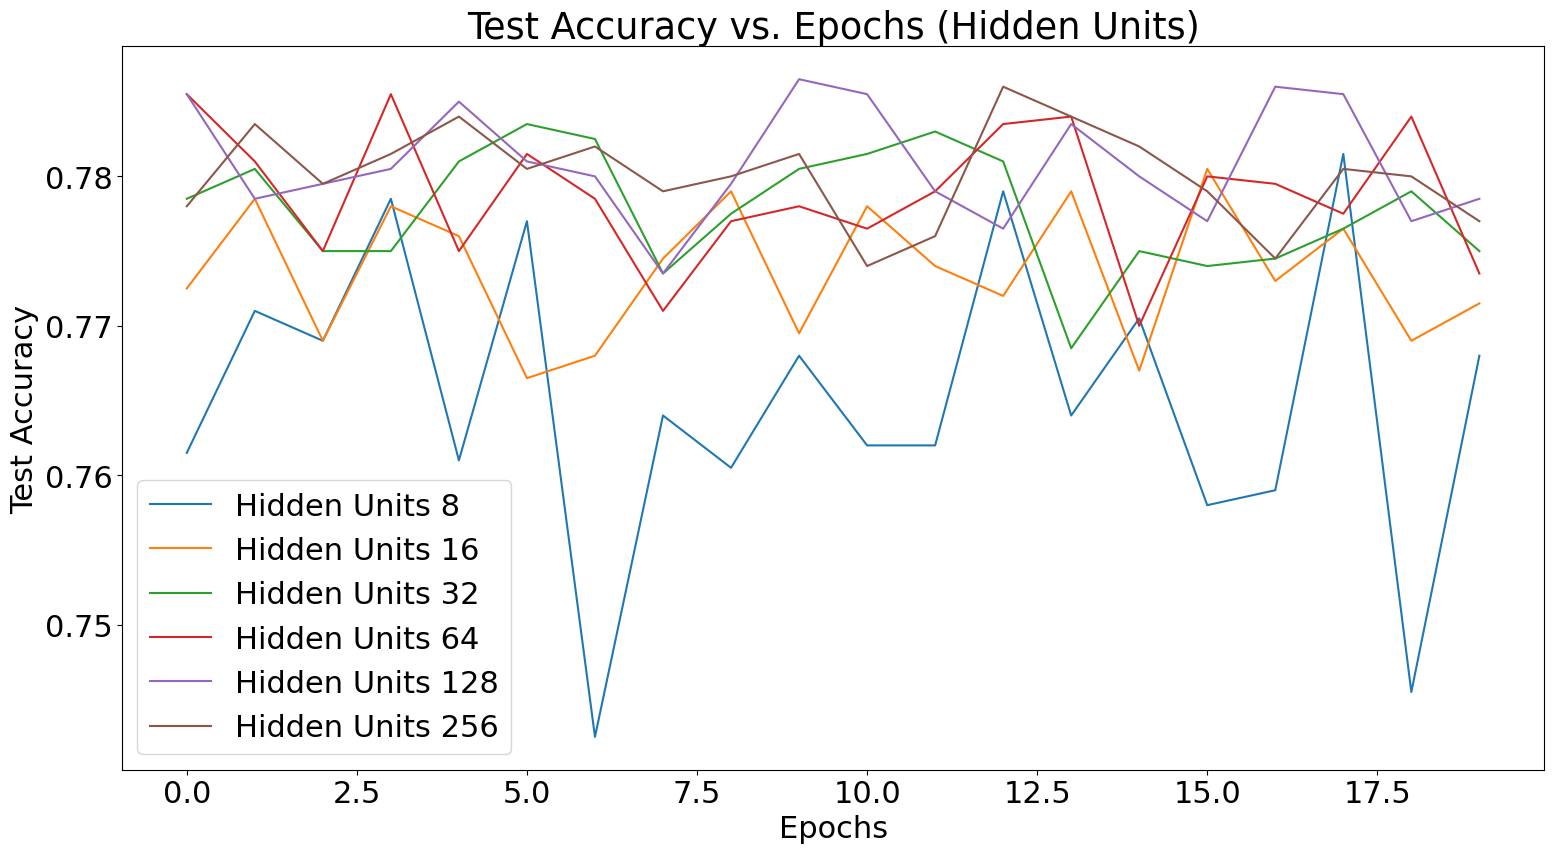

In [ ]:
"""
DHARUN NARAYANAN LAKSHMINARAYANAN KOMETHAGAVELU
"""

from turtle import width
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
font = {'weight' : 'normal','size'   : 22}
matplotlib.rc('font', **font)
import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')



######################################################
# Q1 Implement Init, Forward, and Backward For Layers
######################################################


class SigmoidCrossEntropy:

  # Compute the cross entropy loss after sigmoid. The reason they are put into the same layer is because the gradient has a simpler form
  # logits -- batch_size x num_classes set of scores, logits[i,j] is score of class j for batch element i
  # labels -- batch_size x 1 vector of integer label id (0,1) where labels[i] is the label for batch element i
  #
  # TODO: Output should be a positive scalar value equal to the average cross entropy loss after sigmoid
    def forward(self, logits, labels):
        self.sig = self.sigmoid(logits)
        self.loss = -np.mean(labels * np.log(self.sig + 1e-15) + (1 - labels) * np.log(1 - self.sig + 1e-15))
        self.labels = labels
        return self.loss


  # TODO: Compute the gradient of the cross entropy loss with respect to the the input logits
    def backward(self):
        self.grad = self.sig - self.labels
        return self.grad

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -15, 15)))



class ReLU:

  # TODO: Compute ReLU(input) element-wise
    def forward(self, input):
        self.input = input
        return np.maximum(0, input)

  # TODO: Given dL/doutput, return dL/dinput
    def backward(self, grad):
        grad_input = grad * (self.input > 0)
        return grad_input

  # No parameters so nothing to do during a gradient descent step
    def step(self,step_size, momentum = 0, weight_decay = 0):
        return


class LinearLayer:

  # TODO: Initialize our layer with (input_dim, output_dim) weight matrix and a (1,output_dim) bias vector
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.W = np.random.randn(output_dim, input_dim) * np.sqrt(2 / (input_dim + output_dim))
        self.b = np.zeros((1, output_dim))
        self.grad_weights = None
        self.grad_bias = None
        self.input = None
        self.output = None
        self.prev_grad_weights = np.zeros_like(self.W)
        self.prev_grad_bias = np.zeros_like(self.b)


  # TODO: During the forward pass, we simply compute XW+b
    def forward(self, input):
        self.input = input
        self.output = np.dot(input, self.W.T) + self.b
        return self.output


  # TODO: Backward pass inputs:
  #
  # grad dL/dZ -- For a batch size of n, grad is a (n x output_dim) matrix where
  #         the i'th row is the gradient of the loss of example i with respect
  #         to z_i (the output of this layer for example i)

  # Computes and stores:
  #
  # self.grad_weights dL/dW --  A (input_dim x output_dim) matrix storing the gradient
  #                       of the loss with respect to the weights of this layer.
  #                       This is an summation over the gradient of the loss of
  #                       each example with respect to the weights.
  #
  # self.grad_bias dL/dZ--     A (1 x output_dim) matrix storing the gradient
  #                       of the loss with respect to the bias of this layer.
  #                       This is an summation over the gradient of the loss of
  #                       each example with respect to the bias.

  # Return Value:
  #
  # grad_input dL/dX -- For a batch size of n, grad_input is a (n x input_dim) matrix where
  #               the i'th row is the gradient of the loss of example i with respect
  #               to x_i (the input of this layer for example i)

    def backward(self, grad):
        if grad is None:
            raise ValueError("Gradient is None")
        self.grad_weights = np.dot(self.input.T, grad)
        self.grad_bias = np.sum(grad, axis=0, keepdims=True)
        grad_input = np.dot(grad, self.W)
        return grad_input


  ######################################################
  # Q2 Implement SGD with Weight Decay
  ######################################################
    def step(self, step_size, momentum = 0.8, weight_decay = 0.0):
        self.prev_grad_weights = momentum * self.prev_grad_weights + (1 - momentum) * (self.grad_weights.T + weight_decay * self.W)
        self.prev_grad_bias = momentum * self.prev_grad_bias + (1 - momentum) * self.grad_bias
        self.W -= step_size * self.prev_grad_weights
        self.b -= step_size * self.prev_grad_bias

class FeedForwardNeuralNetwork:

    def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
        if num_layers == 1:
            self.layers = [LinearLayer(input_dim, output_dim)]
        else:
            self.layers = [LinearLayer(input_dim, hidden_dim)]
            self.layers.append(ReLU())  # ReLU activation after input layer
            for _ in range(num_layers - 2):
                self.layers.append(LinearLayer(hidden_dim, hidden_dim))
                self.layers.append(ReLU())  # ReLU activation after each hidden layer
            # Output layer
            self.layers.append(LinearLayer(hidden_dim, output_dim))

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

    def step(self, step_size, momentum, weight_decay):
        for layer in self.layers:
            layer.step(step_size, momentum, weight_decay)


######################################################
# Q4 Implement Evaluation for Monitoring Training
######################################################

# TODO: Given a model, X/Y dataset, and batch size, return the average cross-entropy loss and accuracy over the set
def evaluate(model, X_val, Y_val, batch_size):
  sce = SigmoidCrossEntropy()
  total_loss = 0
  correct = 0

  for i in range(0, X_val.shape[0], batch_size):
    X_batch = X_val[i:i+batch_size]
    Y_batch = Y_val[i:i+batch_size]

    logits = model.forward(X_batch)
    loss = sce.forward(logits, Y_batch)

    total_loss += loss
    predictions = (logits > 0.5).astype(int)
    correct += np.sum(predictions == Y_batch)

  avg_loss = total_loss / (X_val.shape[0] // batch_size)
  accuracy = correct / X_val.shape[0]
  return avg_loss, accuracy


def main():
    # Load data
    data = pickle.load(open('cifar_2class_py3.p', 'rb'))
    X_train = data['train_data']
    Y_train = data['train_labels']
    X_test = data['test_data']
    Y_test = data['test_labels']
    Xmean = np.mean(X_train, axis=0)
    X_train = (X_train - Xmean) / 255.0
    X_test = (X_test - Xmean) / 255.0

    # Parameters
    max_epochs = 20
    width_of_layers = 16
    number_of_layers = 2
    hidden_units_list = [8, 16, 32, 64, 128, 256]
    learning_rates = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
    batch_sizes = [8, 16, 32, 64, 128, 256, 512, 1024]

    # Results storage
    results_batch_size = {}
    results_learning_rate = {}
    results_hidden_units = {}

    for batch_size in batch_sizes:
        logging.info(f"Training with batch size: {batch_size}")
        results_batch_size[batch_size] = []
        for _ in range(max_epochs):
            model = FeedForwardNeuralNetwork(X_train.shape[1], 1, width_of_layers, number_of_layers)
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i + batch_size]
                Y_batch = Y_train[i:i + batch_size]
                logits = model.forward(X_batch)
                sce = SigmoidCrossEntropy()
                loss = sce.forward(logits, Y_batch)
                grad = sce.backward()
                model.backward(grad)
                model.step(0.01, momentum=0.8, weight_decay=0.0)
            val_loss, val_acc = evaluate(model, X_test, Y_test, batch_size)
            results_batch_size[batch_size].append(val_acc)

    for learning_rate in learning_rates:
        logging.info(f"Training with learning rate: {learning_rate}")
        results_learning_rate[learning_rate] = []
        for _ in range(max_epochs):
            model = FeedForwardNeuralNetwork(X_train.shape[1], 1, width_of_layers, number_of_layers)
            for i in range(0, X_train.shape[0], 32):
                X_batch = X_train[i:i + 32]
                Y_batch = Y_train[i:i + 32]
                logits = model.forward(X_batch)
                sce = SigmoidCrossEntropy()
                loss = sce.forward(logits, Y_batch)
                grad = sce.backward()
                model.backward(grad)
                model.step(learning_rate, momentum=0.8, weight_decay=0.0)
            val_loss, val_acc = evaluate(model, X_test, Y_test, 32)
            results_learning_rate[learning_rate].append(val_acc)

    for hidden_units in hidden_units_list:
        logging.info(f"Training with hidden units: {hidden_units}")
        results_hidden_units[hidden_units] = []
        for _ in range(max_epochs):
            model = FeedForwardNeuralNetwork(X_train.shape[1], 1, hidden_units, number_of_layers)
            for i in range(0, X_train.shape[0], 32):
                X_batch = X_train[i:i + 32]
                Y_batch = Y_train[i:i + 32]
                logits = model.forward(X_batch)
                sce = SigmoidCrossEntropy()
                loss = sce.forward(logits, Y_batch)
                grad = sce.backward()
                model.backward(grad)
                model.step(0.01, momentum=0.8, weight_decay=0.0)
            val_loss, val_acc = evaluate(model, X_test, Y_test, 32)
            results_hidden_units[hidden_units].append(val_acc)

    # Plotting
    plt.figure(figsize=(16,9))
    for batch_size, accs in results_batch_size.items():
        plt.plot(accs, label=f"Batch Size {batch_size}")
    plt.xlabel("Epochs")
    plt.ylabel("Test Accuracy")
    plt.title("Test Accuracy vs. Epochs (Batch Size)")
    plt.legend()

    plt.figure(figsize=(16,9))
    for learning_rate, accs in results_learning_rate.items():
        plt.plot(accs, label=f"Learning Rate {learning_rate}")
    plt.xlabel("Epochs")
    plt.ylabel("Test Accuracy")
    plt.title("Test Accuracy vs. Epochs (Learning Rate)")
    plt.legend()

    plt.figure(figsize=(16,9))
    for hidden_units, accs in results_hidden_units.items():
        plt.plot(accs, label=f"Hidden Units {hidden_units}")
    plt.xlabel("Epochs")
    plt.ylabel("Test Accuracy")
    plt.title("Test Accuracy vs. Epochs (Hidden Units)")
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
